In [6]:
!pip install openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize as opt


In [14]:
import numpy as np
import pandas as pd
from scipy import optimize as opt

# ====== LEER EL ARCHIVO ======
df = pd.read_excel("Experimental water adsorption isotherms.xlsx",
                   sheet_name="Water Adsorption Isotherms")

df = df.rename(columns={"Water activity": "aw",
                        "Moisture content (% dry basis)": "Xe"})

# ====== MODELOS ======
def peleg(aw, b0, b1, b2, b3):
    return b0*aw**b1 + b2*aw**b3

def dlp(aw, b0, b1, b2, b3):
    x = np.log(-np.log(aw))
    return b0 + b1*x + b2*x**2 + b3*x**3

# ====== FUNCIÓN DE AJUSTE ======
def fit(model, aw, Xe):
    def chi2(p):
        return np.sum((Xe - model(aw, *p))**2)
    p0=[1,1,1,1]
    res=opt.minimize(chi2,p0,method="Nelder-Mead")
    p=res.x
    red=res.fun/(len(Xe)-4)
    return p, red

# ====== AJUSTE PARA CADA CURVA ======
rows=[]

for (ctype,T), sub in df.groupby(["Type","Temperature"]):
    aw=sub["aw"].values
    Xe=sub["Xe"].values

    pP, chiP = fit(peleg, aw, Xe)
    pD, chiD = fit(dlp, aw, Xe)
    best = "Peleg" if chiP < chiD else "DLP"

    rows.append({
        "Type": ctype,
        "T": T,
        "chi2_Peleg": chiP,
        "chi2_DLP": chiD,
        "Best": best,
        "b0_P": pP[0], "b1_P": pP[1], "b2_P": pP[2], "b3_P": pP[3],
        "b0_D": pD[0], "b1_D": pD[1], "b2_D": pD[2], "b3_D": pD[3]
    })

res = pd.DataFrame(rows)
res


,Type,T,chi2_Peleg,chi2_DLP,Best,b0_P,b1_P,b2_P,b3_P,b0_D,b1_D,b2_D,b3_D
0,Ground-Fine,25,1.225978,0.499231,DLP,29.664617,6.018534,82.804297,418.425877,1.246330,-0.519096,0.737304,-0.966928
1,Ground-Fine,35,0.451533,0.157832,DLP,26.473954,3.757014,-4.924005,3.756984,1.188632,-1.685489,2.220774,0.003360
2,Ground-Fine,45,0.096919,0.126808,Peleg,0.838851,0.496621,20.790797,4.123414,0.691479,-2.379523,2.645965,0.414642
3,Ground-Medium,25,0.450238,0.522211,Peleg,47.258324,10.952655,2.314948,0.212005,1.903917,0.124594,-0.135897,-1.461472
4,Ground-Medium,35,0.040087,0.096872,Peleg,2.326657,0.181327,23.657293,6.258798,1.746424,-1.024091,1.745371,-0.191366
5,Ground-Medium,45,0.047910,0.093984,Peleg,1.490559,0.256261,21.514826,4.769437,1.079987,-1.905437,2.415157,0.227800
6,Roasted beans,25,0.242733,0.623381,Peleg,1148.516399,46.979371,2.731001,0.151710,2.992698,0.495574,-1.664769,-1.299155
7,Roasted beans,35,0.144132,0.150640,Peleg,2.357748,0.070189,27.587987,12.788537,2.284838,0.292478,-0.226762,-0.793021
8,Roasted beans,45,0.056515,0.062548,Peleg,2.318381,0.099994,28.545286,10.027872,2.022859,0.097130,0.370288,-0.769502


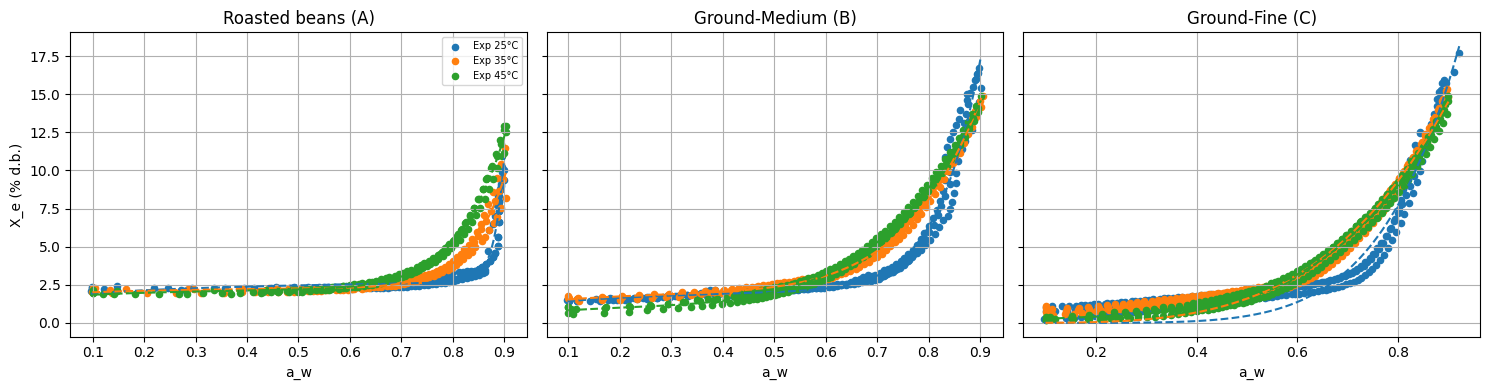

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Para usar los parámetros ya calculados:
# res es el DataFrame de resultados

tipos = ["Roasted beans", "Ground-Medium", "Ground-Fine"]
titulos = ["Roasted beans (A)", "Ground-Medium (B)", "Ground-Fine (C)"]

fig, axes = plt.subplots(1, 3, figsize=(15,4), sharey=True)

for ax, ctype, titulo in zip(axes, tipos, titulos):
    for T in sorted(df["Temperature"].unique()):
        sub = df[(df["Type"] == ctype) & (df["Temperature"] == T)]
        aw = sub["aw"].values
        Xe = sub["Xe"].values
        ax.scatter(aw, Xe, label=f"Exp {T}°C", s=20)

        fila = res[(res["Type"]==ctype) & (res["T"]==T)].iloc[0]
        pP = [fila["b0_P"], fila["b1_P"], fila["b2_P"], fila["b3_P"]]

        aw_grid = np.linspace(aw.min(), aw.max(), 200)
        XeP = peleg(aw_grid, *pP)
        ax.plot(aw_grid, XeP, linestyle="--")

    ax.set_title(titulo)
    ax.set_xlabel("a_w")
    ax.grid(True)

axes[0].set_ylabel("X_e (% d.b.)")
axes[0].legend(fontsize=7)
plt.tight_layout()
plt.show()
